In [1]:
# TensorFlow 라이브러리를 사용한 오토인코더 구현 예.
# 이 예제는 손으로 쓴 숫자들을 모와 둔 MNIST 데이터베이스를 사용하고 있습니다.

# 수정자: 정 경태
# Project: https://github.com/nlintz/TensorFlow-Tutorials

In [2]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# MINST 데이터 가져오기
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
# 파라메터(Parameters)
learning_rate = 0.001
training_epochs = 10
batch_size = 128
display_step = 1

# 네트워크 파라메터(Parameters)
mnist_width = 28
n_visible = mnist_width * mnist_width
n_hidden = 500
corruption_level = 0.3

In [4]:
# create node for input data
X = tf.placeholder("float", [None, n_visible], name='X')

# create node for corruption mask
mask = tf.placeholder("float", [None, n_visible], name='mask')

# create nodes for hidden variables
W_init_max = 4 * np.sqrt(6. / (n_visible + n_hidden))
W_init = tf.random_uniform(shape=[n_visible, n_hidden],
                           minval=-W_init_max,
                           maxval=W_init_max)

W = tf.Variable(W_init, name='W')
b = tf.Variable(tf.zeros([n_hidden]), name='b')

W_prime = tf.transpose(W)  # tied weights between encoder and decoder
b_prime = tf.Variable(tf.zeros([n_visible]), name='b_prime')

# 모델
def model(X, mask, W, b, W_prime, b_prime):
    tilde_X = mask * X  # corrupted X

    Y = tf.nn.sigmoid(tf.matmul(tilde_X, W) + b)  # hidden state
    Z = tf.nn.sigmoid(tf.matmul(Y, W_prime) + b_prime)  # reconstructed input
    return Z

# 모델 생성
Z = model(X, mask, W, b, W_prime, b_prime)

# 손실 및 최적화 정의
cost = tf.reduce_sum(tf.pow(X - Z, 2))  # minimize squared error
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)  # construct an optimizer
predict_op = Z

# MNIST 데이터 불러오기
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

In [5]:
# 세션 설정
session_conf = tf.ConfigProto()
session_conf.gpu_options.allow_growth = True

# 그래프 실행
with tf.Session(config=session_conf) as sess:
    # you need to initialize all variables
    tf.initialize_all_variables().run()

    for epoch in range(training_epochs):
        for start, end in zip(range(0, len(trX), batch_size), range(batch_size, len(trX)+1, batch_size)):
            input_ = trX[start:end]
            mask_np = np.random.binomial(1, 1 - corruption_level, input_.shape)
            sess.run(train_op, feed_dict={X: input_, mask: mask_np})
            
        mask_np = np.random.binomial(1, 1 - corruption_level, teX.shape)
        
        # 매 epoch 스텝 마다 화면에 로그 출력
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(sess.run(cost, feed_dict={X: teX, mask: mask_np})/teX.size))
        
    # 100개의 이미지들에 대한 추론값 저장
    mask_np = np.random.binomial(1, 1 - corruption_level, teX[:100].shape)
    predicted_imgs = sess.run(predict_op, feed_dict={X: teX[:100], mask: mask_np})
    input_imgs = teX[:100]

Epoch: 0001 cost= 0.014876234
Epoch: 0002 cost= 0.012726770
Epoch: 0003 cost= 0.011820612
Epoch: 0004 cost= 0.011286952
Epoch: 0005 cost= 0.010936627
Epoch: 0006 cost= 0.010740733
Epoch: 0007 cost= 0.010530320
Epoch: 0008 cost= 0.010368659
Epoch: 0009 cost= 0.010290526
Epoch: 0010 cost= 0.010169476


In [6]:
## 재구성에 대한 시각화 펑션
def vis(images, save_name):
    dim = images.shape[0]
    n_image_rows = int(np.ceil(np.sqrt(dim)))
    n_image_cols = int(np.ceil(dim * 1.0/n_image_rows))
    gs = gridspec.GridSpec(n_image_rows,n_image_cols,top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.)
    for g,count in zip(gs,range(int(dim))):
        ax = plt.subplot(g)
        ax.imshow(images[count,:].reshape((28,28)))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.savefig(save_name + '_vis.png')

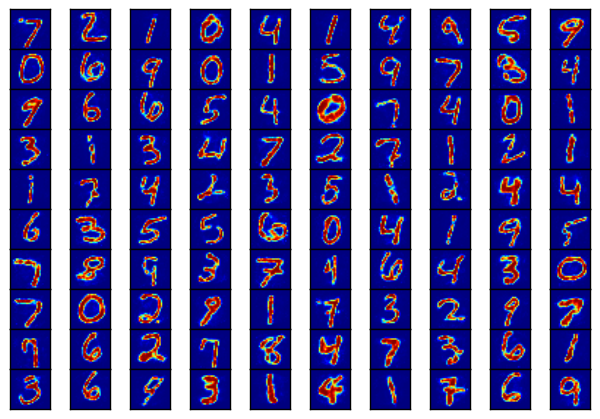

In [7]:
# 재구성 된 이미지들 그리기
vis(predicted_imgs,'pred')

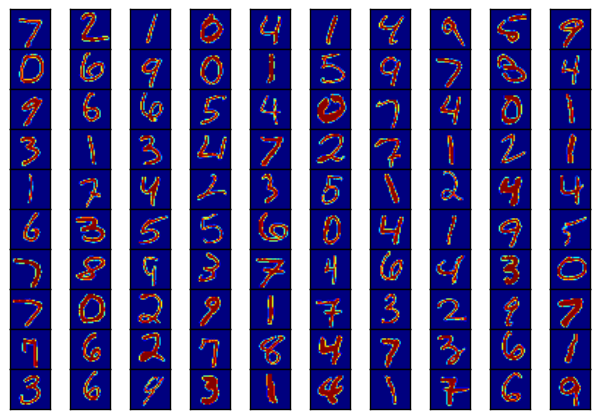

In [8]:
# 입력 이미지와 재구성 이미지를 비교해서 뿌리기
vis(input_imgs,'in')